In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Defining global economic downturn periods
dot_bomb = ["2001-03-01", "2001-11-30"]
great_rec = ["2007-12-01", "2009-06-30"]
covid = ["2020-02-01", "2020-04-30"]

def to_dataframe(filename):
    """
    Load and clean the index data from a CSV file.
    The CSV file should have at least these columns:
    Date, Open, High, Low, Close, Adj Close, Normalized, Volume
    """
    print(f"Loading data from {filename}...")
    df = pd.read_csv(filename)
    df["Date"] = pd.DatetimeIndex(df["Date"])
    df = df.set_index("Date")
    # Drop rows with NaT if any
    df = df[~df.index.isnull()]

    numeric_cols = ["Open", "High", "Low", "Close", "Adj Close", "Normalized", "Volume"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=numeric_cols, inplace=True)
    print(f"Data loaded successfully from {filename}!")
    return df

def get_report(df, name="Data"):
    """
    Generate an EDA report using ydata-profiling.
    """
    print(f"Generating EDA report for {name}...")
    profile = ProfileReport(df, title=f"{name} EDA Report", explorative=True)
    report_file = f"{name}_report.html"
    profile.to_file(report_file)
    print(f"EDA report saved to {report_file}")

def std_returns(df, period, col="Adj Close"):
    """
    Calculate the standard deviation of returns for a given period and column.
    """
    subset = df.loc[(df.index >= period[0]) & (df.index <= period[1]), col]
    return subset.pct_change().std()

def rolling_stats(df, col="Adj Close", period=None, win_size=15):
    """
    Compute and plot rolling min, max, mean, and std for a given column
    """
    if period is None:
        df_col = df[col]
    else:
        df_col = df.loc[period[0]:period[1], col]

    rolling_returns = df_col.rolling(win_size)
    features = rolling_returns.aggregate(["min", "max", "mean", "std"])
    ax = features.plot(title=f"Rolling Stats ({col}, window={win_size})", figsize=(10,6))
    df_col.plot(ax=ax, color="k", alpha=0.5)
    ax.legend()
    plt.show()

def bol_bands(df, col="Adj Close", window_size=13, num_std=2):
    """
    Compute and plot Bollinger Bands for a given column.
    """
    rolling_mean = df[col].rolling(window_size).mean()
    rolling_std = df[col].rolling(window_size).std()

    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[col], label=f"{col} Price")
    plt.plot(df.index, rolling_mean, label="Rolling Mean", color="red")
    plt.plot(df.index, upper_band, label="Upper Band", color="black")
    plt.plot(df.index, lower_band, label="Lower Band", color="black")
    plt.fill_between(df.index, lower_band, upper_band, color="grey", alpha=0.2)
    plt.title("Bollinger Bands")
    plt.xlabel("Year")
    plt.ylabel(f"{col} Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

def monte_carlo_simulation(df, period, col="Adj Close", horizon=60, num_simulations=100000):
    """
    Performs a Monte Carlo simulation to forecast potential future outcomes
    for an index assuming a downturn scenario similar to the period window.
    
    """"
    if downturn_returns.empty:
        print("No data available for the specified period. Cannot run Monte Carlo simulation.")
        return

    last_price = downturn_data.iloc[-1]

    # Run simulations
    simulated_final_prices = []
    all_simulated_returns = []  # Store daily returns for analysis

    for _ in range(num_simulations):
        # Randomly sample returns with replacement from the historical distribution
        sampled_returns = np.random.choice(downturn_returns, size=horizon, replace=True)
        final_price = last_price * np.prod(1 + sampled_returns)
        simulated_final_prices.append(final_price)
        all_simulated_returns.append(sampled_returns)

    simulated_final_prices = np.array(simulated_final_prices)
    all_simulated_returns = np.array(all_simulated_returns)  # shape: (num_simulations, horizon)

    # Plot the distribution of final outcomes
    plt.figure(figsize=(10,6))
    plt.hist(simulated_final_prices, bins=50, alpha=0.7, edgecolor='black')
    plt.title(f"Monte Carlo Simulation Distribution of Outcomes\n(Period: {period[0]} to {period[1]})")
    plt.xlabel("Final Simulated Price")
    plt.ylabel("Frequency")
    plt.grid(True)

    # Add summary statistics for final price
    mean_price = np.mean(simulated_final_prices)
    median_price = np.median(simulated_final_prices)
    std_dev_price = np.std(simulated_final_prices)

    plt.axvline(mean_price, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_price:.2f}")
    plt.axvline(median_price, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_price:.2f}")
    plt.legend()
    plt.show()

    # Print summary statistics for final outcomes
    print(f"Monte Carlo Simulation Summary ({period[0]} to {period[1]}):")
    print(f"Mean final price: {mean_price:.2f}")
    print(f"Median final price: {median_price:.2f}")
    print(f"Std Dev of final price: {std_dev_price:.2f}")

    # Daily returns statistics
    daily_mean_returns = np.mean(all_simulated_returns, axis=0)
    daily_median_returns = np.median(all_simulated_returns, axis=0)
    daily_std_returns = np.std(all_simulated_returns, axis=0)

    print("\nDaily Returns Summary Across All Simulations:")
    print(f"Mean of daily returns (averaged over {horizon} days): {np.mean(daily_mean_returns)*100:.2f}%")
    print(f"Median of daily returns (averaged over {horizon} days): {np.mean(daily_median_returns)*100:.2f}%")
    print(f"Average daily returns standard deviation: {np.mean(daily_std_returns)*100:.2f}%")

def combined_period_monte_carlo_simulation(df, periods, col="Adj Close", horizon=60, num_simulations=100000):

    # Combine returns from all periods
    combined_returns = pd.Series(dtype=float)

    for period in periods:
        downturn_data = df.loc[(df.index >= period[0]) & (df.index <= period[1]), col]
        period_returns = downturn_data.pct_change().dropna()
        combined_returns = pd.concat([combined_returns, period_returns])

    if combined_returns.empty:
        print("No data available for the specified periods. Cannot run Monte Carlo simulation.")
        return

    last_period = periods[-1]
    last_price = df.loc[(df.index >= last_period[0]) & (df.index <= last_period[1]), col].iloc[-1]

    simulated_final_prices = []
    all_simulated_returns = []

    for _ in range(num_simulations):
        sampled_returns = np.random.choice(combined_returns, size=horizon, replace=True)
        final_price = last_price * np.prod(1 + sampled_returns)
        simulated_final_prices.append(final_price)
        all_simulated_returns.append(sampled_returns)

    simulated_final_prices = np.array(simulated_final_prices)
    all_simulated_returns = np.array(all_simulated_returns)  # shape: (num_simulations, horizon)

    # Plot final prices distribution
    plt.figure(figsize=(10,6))
    plt.hist(simulated_final_prices, bins=50, alpha=0.7, edgecolor='black')
    title_periods = " + ".join([f"{p[0]} to {p[1]}" for p in periods])
    plt.title(f"Monte Carlo Simulation Distribution of Outcomes\n(Combined Periods: {title_periods})")
    plt.xlabel("Final Simulated Price")
    plt.ylabel("Frequency")
    plt.grid(True)

    mean_price = np.mean(simulated_final_prices)
    median_price = np.median(simulated_final_prices)
    std_dev_price = np.std(simulated_final_prices)

    plt.axvline(mean_price, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_price:.2f}")
    plt.axvline(median_price, color='g', linestyle='dashed', linewidth=2, label=f"Median: {median_price:.2f}")
    plt.legend()
    plt.show()

    print(f"Monte Carlo Simulation Summary (Combined Periods):")
    print(f"Mean final price: {mean_price:.2f}")
    print(f"Median final price: {median_price:.2f}")
    print(f"Std Dev of final price: {std_dev_price:.2f}")

    # Daily returns statistics
    daily_mean_returns = np.mean(all_simulated_returns, axis=0)
    daily_median_returns = np.median(all_simulated_returns, axis=0)
    daily_std_returns = np.std(all_simulated_returns, axis=0)

    print("\nDaily Returns Summary Across All Simulations (Combined):")
    print(f"Mean of daily returns (averaged over {horizon} days): {np.mean(daily_mean_returns)*100:.2f}%")
    print(f"Median of daily returns (averaged over {horizon} days): {np.mean(daily_median_returns)*100:.2f}%")
    print(f"Average daily returns standard deviation: {np.mean(daily_std_returns)*100:.2f}%")


In [71]:
# Load datasets for both indices
wilshire_df = to_dataframe("wilshire_5000_data.csv")  
shanghai_df = to_dataframe("shanghai_composite_data.csv")  


Loading data from wilshire_5000_data.csv...
Data loaded successfully from wilshire_5000_data.csv!
Loading data from shanghai_composite_data.csv...
Data loaded successfully from shanghai_composite_data.csv!


In [73]:
# Generate EDA reports
#get_report(wilshire_df, name="Wilshire_5000")
#get_report(shanghai_df, name="Shanghai_Composite")


Generating EDA report for Wilshire_5000...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA report saved to Wilshire_5000_report.html
Generating EDA report for Shanghai_Composite...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA report saved to Shanghai_Composite_report.html


In [74]:
# Volatility analysis during known global downturns
downturns = {
    "Dot-Com Bubble": dot_bomb,
    "Great Recession": great_rec,
    "COVID Crash": covid
}

print("Volatility Analysis During Downturns:")
for name, period in downturns.items():
    wilshire_vol = std_returns(wilshire_df, period)
    shanghai_vol = std_returns(shanghai_df, period)
    print(f"{name}:")
    print(f"  Wilshire 5000 Volatility: {wilshire_vol}")
    print(f"  Shanghai Composite Volatility: {shanghai_vol}")


Volatility Analysis During Downturns:
Dot-Com Bubble:
  Wilshire 5000 Volatility: 0.014162952094112845
  Shanghai Composite Volatility: 0.014485206086698338
Great Recession:
  Wilshire 5000 Volatility: 0.024064955640371765
  Shanghai Composite Volatility: 0.025492608899669436
COVID Crash:
  Wilshire 5000 Volatility: 0.039320488051527734
  Shanghai Composite Volatility: 0.014134969522142774



Rolling Stats (Wilshire 5000) During the Great Recession:


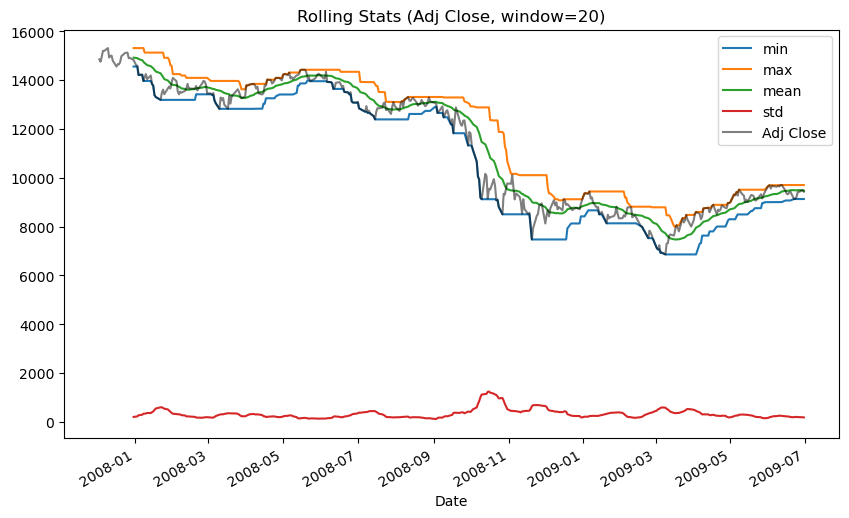

In [75]:
# Example rolling stats during the Great Recession for Wilshire
print("\nRolling Stats (Wilshire 5000) During the Great Recession:")
rolling_stats(wilshire_df, col="Adj Close", period=great_rec, win_size=20)


Bollinger Bands (Shanghai Composite) Over Entire Period:


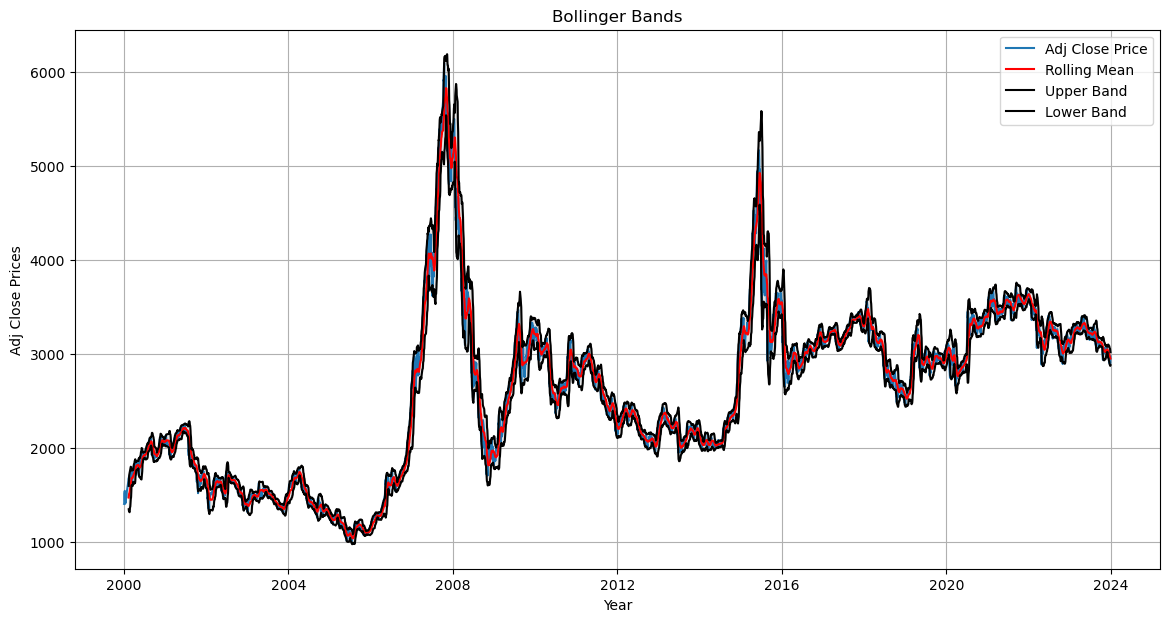

In [76]:
# Example Bollinger Bands for Shanghai Composite
print("Bollinger Bands (Shanghai Composite) Over Entire Period:")
bol_bands(shanghai_df, col="Adj Close", window_size=20, num_std=2)



Monte Carlo Simulation (Wilshire 5000) - COVID-like scenario:


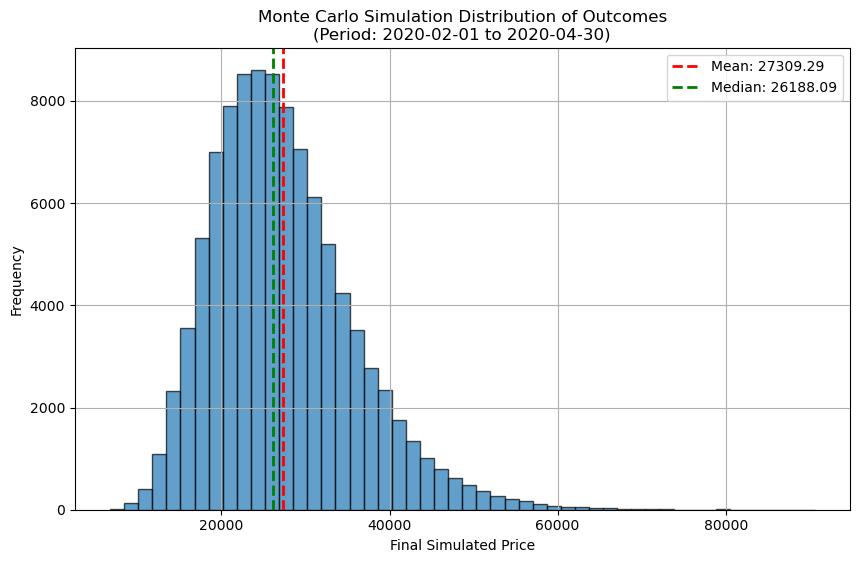

Monte Carlo Simulation Summary (2020-02-01 to 2020-04-30):
Mean final price: 27309.29
Median final price: 26188.09
Std Dev of final price: 8428.28

Daily Returns Summary Across All Simulations:
Mean of daily returns (averaged over 60 days): -0.12%
Median of daily returns (averaged over 60 days): -0.04%
Average daily returns standard deviation: 3.90%

Monte Carlo Simulation (Shanghai Composite) - COVID-like scenario:


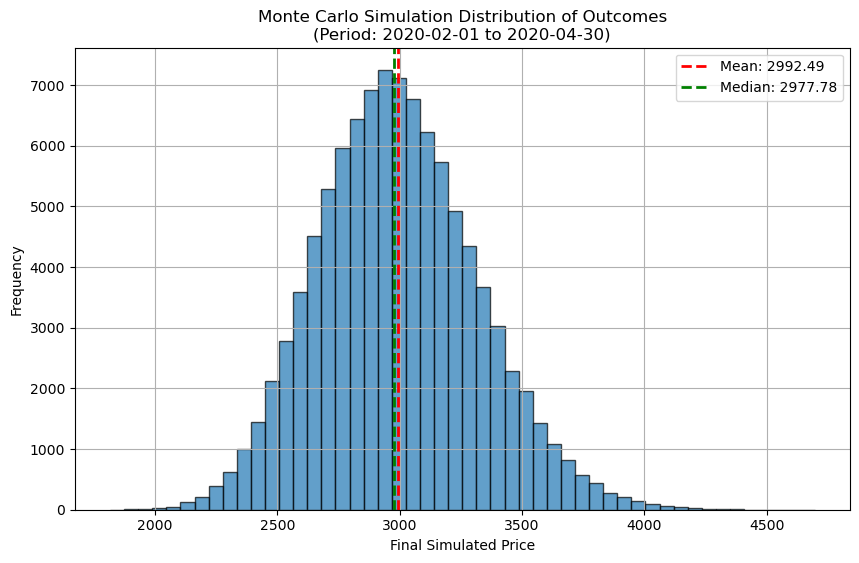

Monte Carlo Simulation Summary (2020-02-01 to 2020-04-30):
Mean final price: 2992.49
Median final price: 2977.78
Std Dev of final price: 325.93

Daily Returns Summary Across All Simulations:
Mean of daily returns (averaged over 60 days): 0.08%
Median of daily returns (averaged over 60 days): 0.19%
Average daily returns standard deviation: 1.40%


In [77]:
# Monte Carlo Simulation for all defined scenarios with 100,000 simulations
print("\nMonte Carlo Simulation (Wilshire 5000) - COVID-like scenario:")
monte_carlo_simulation(wilshire_df, covid, col="Adj Close", horizon=60, num_simulations=100000)

print("\nMonte Carlo Simulation (Shanghai Composite) - COVID-like scenario:")
monte_carlo_simulation(shanghai_df, covid, col="Adj Close", horizon=60, num_simulations=100000)



Monte Carlo Simulation (Wilshire 5000) - Dot-Com Bubble scenario:


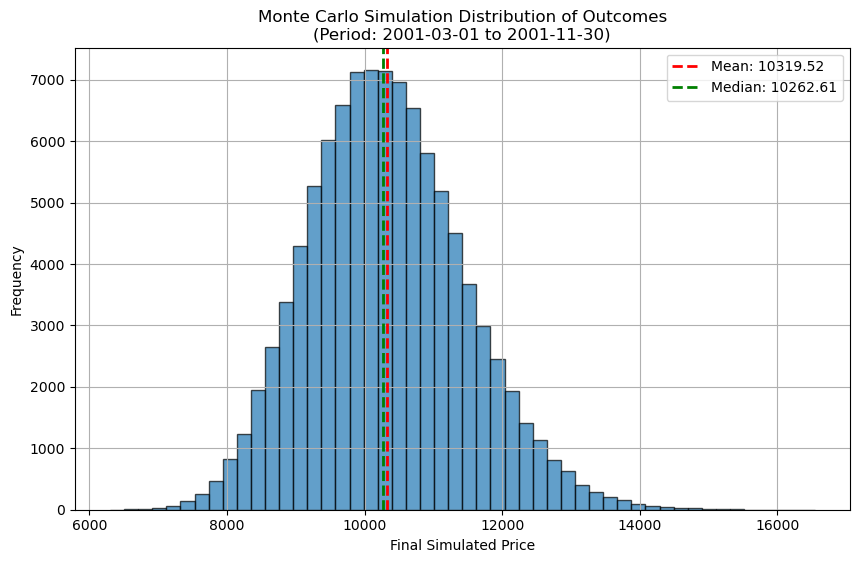

Monte Carlo Simulation Summary (2001-03-01 to 2001-11-30):
Mean final price: 10319.52
Median final price: 10262.61
Std Dev of final price: 1136.12

Daily Returns Summary Across All Simulations:
Mean of daily returns (averaged over 60 days): -0.03%
Median of daily returns (averaged over 60 days): -0.05%
Average daily returns standard deviation: 1.41%

Monte Carlo Simulation (Shanghai Composite) - Dot-Com Bubble scenario:


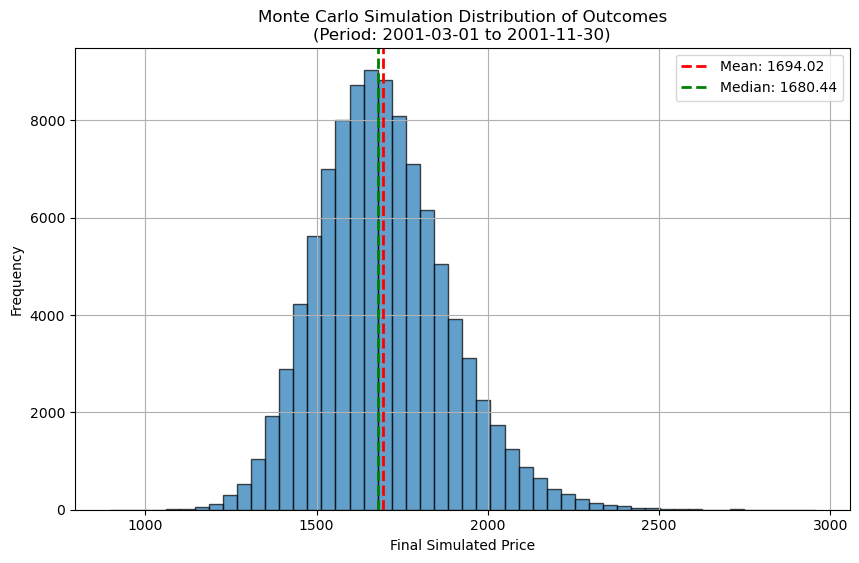

Monte Carlo Simulation Summary (2001-03-01 to 2001-11-30):
Mean final price: 1694.02
Median final price: 1680.44
Std Dev of final price: 190.81

Daily Returns Summary Across All Simulations:
Mean of daily returns (averaged over 60 days): -0.05%
Median of daily returns (averaged over 60 days): 0.02%
Average daily returns standard deviation: 1.44%

Monte Carlo Simulation (Wilshire 5000) - Great Recession scenario:


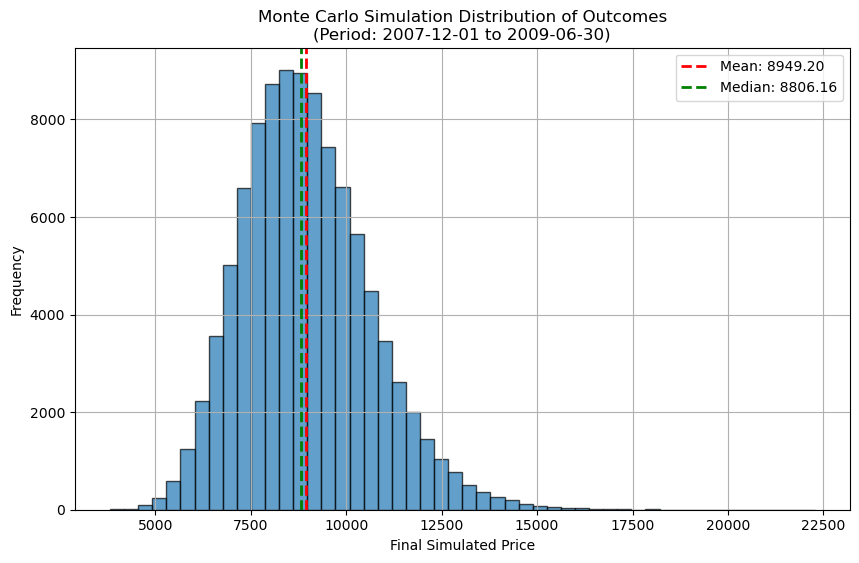

Monte Carlo Simulation Summary (2007-12-01 to 2009-06-30):
Mean final price: 8949.20
Median final price: 8806.16
Std Dev of final price: 1682.00

Daily Returns Summary Across All Simulations:
Mean of daily returns (averaged over 60 days): -0.09%
Median of daily returns (averaged over 60 days): -0.01%
Average daily returns standard deviation: 2.40%

Monte Carlo Simulation (Shanghai Composite) - Great Recession scenario:


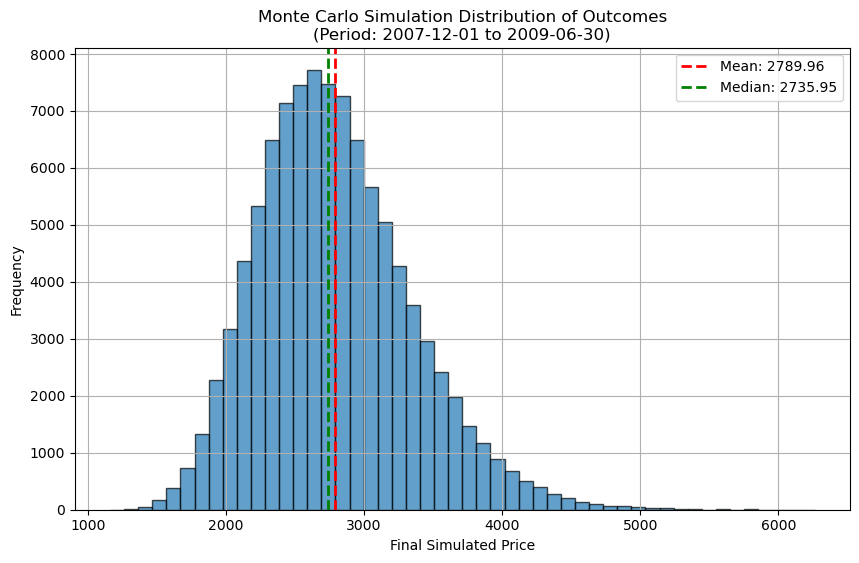

Monte Carlo Simulation Summary (2007-12-01 to 2009-06-30):
Mean final price: 2789.96
Median final price: 2735.95
Std Dev of final price: 557.20

Daily Returns Summary Across All Simulations:
Mean of daily returns (averaged over 60 days): -0.10%
Median of daily returns (averaged over 60 days): -0.00%
Average daily returns standard deviation: 2.54%


In [78]:
# Additional Monte Carlo simulations for other scenarios
print("\nMonte Carlo Simulation (Wilshire 5000) - Dot-Com Bubble scenario:")
monte_carlo_simulation(wilshire_df, dot_bomb, col="Adj Close", horizon=60, num_simulations=100000)

print("\nMonte Carlo Simulation (Shanghai Composite) - Dot-Com Bubble scenario:")
monte_carlo_simulation(shanghai_df, dot_bomb, col="Adj Close", horizon=60, num_simulations=100000)

print("\nMonte Carlo Simulation (Wilshire 5000) - Great Recession scenario:")
monte_carlo_simulation(wilshire_df, great_rec, col="Adj Close", horizon=60, num_simulations=100000)

print("\nMonte Carlo Simulation (Shanghai Composite) - Great Recession scenario:")
monte_carlo_simulation(shanghai_df, great_rec, col="Adj Close", horizon=60, num_simulations=100000)



Monte Carlo Simulation (Wilshire 5000) - Combined Dot-Com + Great Recession + COVID scenario:


/var/folders/qv/754rlbqs05d679jx_nm008ph0000gn/T/ipykernel_61094/2237955638.py:173: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_returns = pd.concat([combined_returns, period_returns])


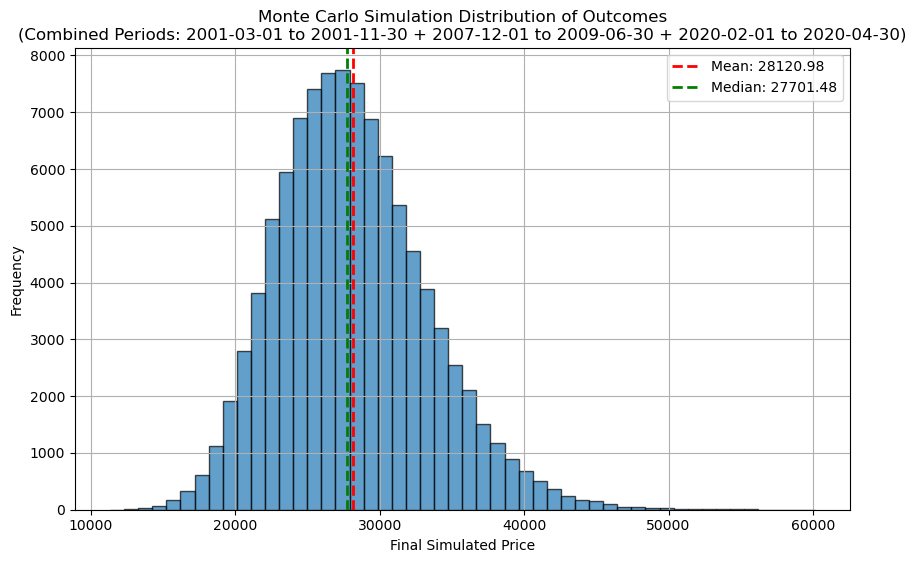

Monte Carlo Simulation Summary (Combined Periods):
Mean final price: 28120.98
Median final price: 27701.48
Std Dev of final price: 5203.93

Daily Returns Summary Across All Simulations (Combined):
Mean of daily returns (averaged over 60 days): -0.07%
Median of daily returns (averaged over 60 days): -0.02%
Average daily returns standard deviation: 2.36%

Monte Carlo Simulation (Shanghai Composite) - Combined Dot-Com + Great Recession + COVID scenario:


/var/folders/qv/754rlbqs05d679jx_nm008ph0000gn/T/ipykernel_61094/2237955638.py:173: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_returns = pd.concat([combined_returns, period_returns])


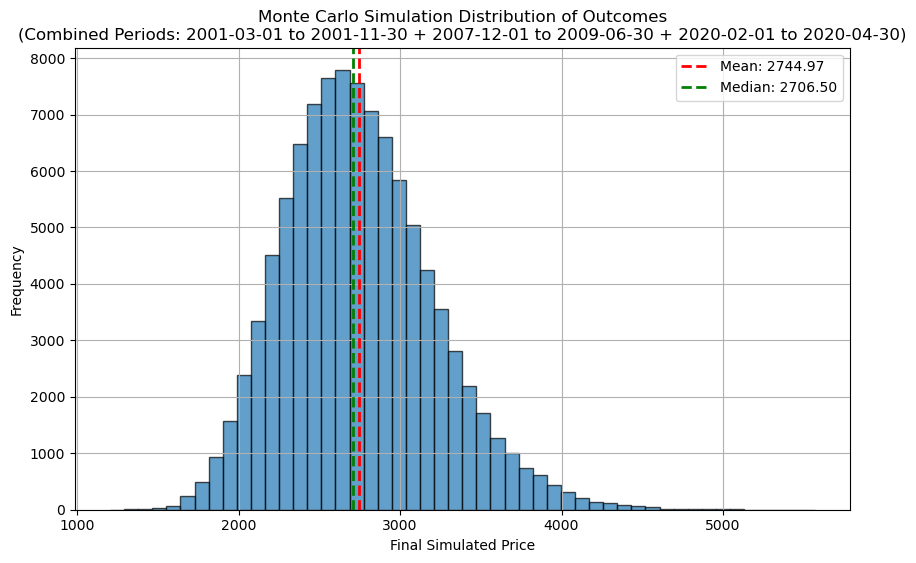

Monte Carlo Simulation Summary (Combined Periods):
Mean final price: 2744.97
Median final price: 2706.50
Std Dev of final price: 465.63

Daily Returns Summary Across All Simulations (Combined):
Mean of daily returns (averaged over 60 days): -0.07%
Median of daily returns (averaged over 60 days): 0.03%
Average daily returns standard deviation: 2.18%


In [79]:
# Combined Monte Carlo simulation scenario using Dot-Com, Great Recession, and COVID data
print("\nMonte Carlo Simulation (Wilshire 5000) - Combined Dot-Com + Great Recession + COVID scenario:")
combined_periods = [dot_bomb, great_rec, covid]
combined_period_monte_carlo_simulation(wilshire_df, combined_periods, col="Adj Close", horizon=60, num_simulations=100000)

print("\nMonte Carlo Simulation (Shanghai Composite) - Combined Dot-Com + Great Recession + COVID scenario:")
combined_period_monte_carlo_simulation(shanghai_df, combined_periods, col="Adj Close", horizon=60, num_simulations=100000)
